In [1]:
import scipy.io
import os
import sys
sys.path.insert(0,'..')
from rnn.model import RNN
from rnn.task import trial_generator
import numpy as np
from analysis.tf_utils import *
from analysis.analysis_utils import *
from scipy.stats import zscore
from itertools import permutations
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.animation import FuncAnimation
# from parula import Parula
from cycler import cycler
from analysis.summary import run_summary
from matplotlib import gridspec
from matplotlib.ticker import StrMethodFormatter
import pickle
%matplotlib inline

# Experiment settings

In [2]:
base_dir = ""
task_dir = "datasweep_main.pkl"


summary_settings = {
    "upsample" : 1, # Increase temporal resolution
    "ref_phase" : "sine", # Reference phase for 'spike-phase' histogram, either sine or LFP
    "onlyGaba" : False,  # Only use inhibitory neurons for calculating LFP
    "cutoff_p": 10e-3, # For Wilc p test
    "normalize_fr_extract":  True,  # Normalize extracted firing rates
    "n_trials": 224,  # Number trials used in analysis
    "randomize_onset": False, # Randomise stimulus onset
    "delay_ms": 2500, # Delay time in ms
    "disable_noise": False, # With or without noise
    "freqs_l": np.logspace(*np.log10([1, 25]), num=50), # Frequencies for spectrograms
    "balance_trials": True, # Draw trials with balanced proportion of each stimuli
    "substr_mean_LFP": False, # Substract mean LFP
    "delay_buffer1": 25, # Disregard short period after stimulus offset
    "delay_buffer2": 25, # Disregard short period before probe onset
    "nbins": 20, # Number of bins for 'spike' phase histograms
    "common_baseline" : True, # Common baseline
    "freqs": [1, 1.5, 1.75, 2.04, 2.37, 2.75, 3.21, 3.73, 4.35, 5] # Frequencies for vex plots
}
pltcolors, pltcolors_alt = steffiscolours()


# Run or load summary over many models

In [3]:
model_dir = os.path.join(base_dir, "..", "models/sweep_main")
data_dir = "../data/"+str(task_dir)
data_list, summary_settings = run_summary(summary_settings, model_dir, data_dir)


# Generate plots

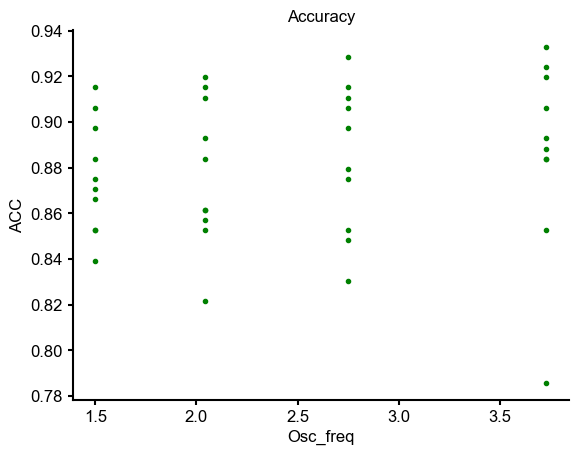

In [4]:
# Plot accuracies of all trained models

acc_threshold = 0.70
acc_indices = []
for i in range(len(data_list["acc"])):
    if data_list["acc"][i]>acc_threshold:
        plt.scatter(data_list["loss_f"][i], data_list["acc"][i], color = 'green')
        acc_indices.append(i)
    else:
        plt.scatter(data_list["loss_f"][i], data_list["acc"][i], color = 'red')

plt.xlabel("Osc_freq")
plt.ylabel("ACC")
plt.title("Accuracy");

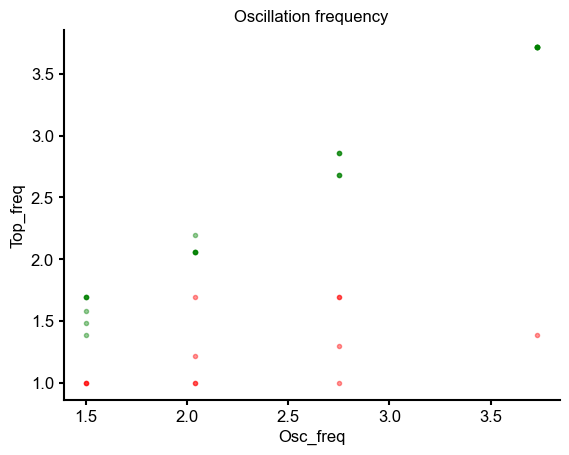

In [5]:
# Plot oscillation frequency for all trained models

fr_l = data_list["summary_settings"]["freqs_l"]
plt_indices = []
for i in acc_indices:
    osc_freq = fr_l[np.argmax(np.mean(data_list["post_spectrum"][i],axis=1))]
    
    if np.isclose(data_list["loss_f"][i], osc_freq, atol=.3):
        plt.scatter(data_list["loss_f"][i],osc_freq, color = 'green', alpha = 0.4)
        plt_indices.append(i)

    else:
        plt.scatter(data_list["loss_f"][i], osc_freq, color = 'red', alpha = 0.4)
plt.xlabel("Osc_freq")
plt.ylabel("Top_freq")
plt.title("Oscillation frequency");


Including frequency 1.5 n = 7
Including frequency 2.04 n = 6
Including frequency 2.75 n = 6
Including frequency 3.73 n = 9


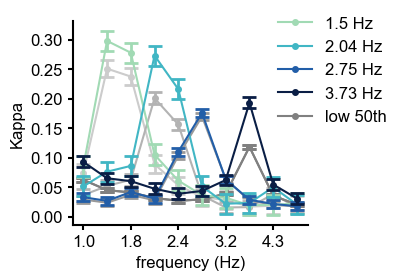

In [11]:
# Plot Kappa per frequency, upper versus lower percentile d'
eps=1e-7
kappa_all =([np.array(data_list["kappas"][i][:,np.mean(data_list["vex"][i],axis=0)>eps]).T for i in plt_indices])
low_kappa_all = ([np.array(data_list["low_kappas"][i][:,np.mean(data_list["low_vex"][i],axis=0)>eps]).T for i in plt_indices])

shcolors = [[0.8,0.8,0.8],[0.7,0.7,0.7],[0.6,0.6,0.6],[0.5,0.5,0.5]]

kappas = []
kappas_se = []
low_kappas = []
low_kappas_se = []

frs = [1.5, 2.04, 2.75, 3.73]
atol = [0.1,0.1,0.1,0.1]
for fri, fr in enumerate(frs):
    kappa = [] 
    low_kappa = []
    incl_freq = False
    for i, ni in enumerate(plt_indices):
        if np.isclose(data_list["loss_f"][ni],fr, atol = atol[fri]):
            incl_freq=True
            kappa.append(kappa_all[i])
            low_kappa.append(low_kappa_all[i])

    if incl_freq:
        print("Including frequency " + str(fr) + " n = " + str(len(kappa)))
        kappas.append(np.mean(np.concatenate(kappa),axis = 0))
        kappas_se.append(np.std([np.mean(kappa[i]) for i in range(len(kappa))])/np.sqrt(len(kappa)))
        low_kappas.append(np.mean(np.concatenate(low_kappa),axis = 0))
        low_kappas_se.append(np.std([np.mean(low_kappa[i]) for i in range(len(low_kappa))])/np.sqrt(len(low_kappa)))
        




with mpl.rc_context(fname="matplotlibrc"):

    fig, axs = plt.subplots(1, figsize=(3.2, 2.7))
    fig.tight_layout()
    for i in range(4):
        axs.errorbar(
            np.arange(len(summary_settings["freqs"])),
            kappas[i],
            kappas_se[i],
            marker="o",
            color=pltcolors_alt[i],
            zorder=i+5,
            capsize=5,
            elinewidth=2,
            markeredgewidth=2,
            label=str(frs[i])+" Hz",
        )  

        axs.errorbar(
            np.arange(len(summary_settings["freqs"])),
            low_kappas[i],
            low_kappas_se[i],
            marker="o",
            color=shcolors[i],
            zorder=i,
            capsize=5,
            elinewidth=2,
            markeredgewidth=2,
        )
    
    axs.errorbar(
        np.arange(len(summary_settings["freqs"])),
        low_kappas[i],
        low_kappas_se[i],
        marker="o",
        color=shcolors[i],
        zorder=i,
        capsize=5,
        elinewidth=2,
        markeredgewidth=2,
        label="low 50th",
    )
    axs.set_yticks(np.arange(0, 0.32, 0.05))

    axs.set_xticks(np.arange(len(summary_settings["freqs"]))[::2])
    axs.set_xticklabels(["{:.1f}".format(fr) for fr in summary_settings["freqs"][::2]])
    axs.spines["right"].set_visible(False)
    axs.spines["top"].set_visible(False)
    axs.set_ylabel("Kappa")
    axs.set_xlabel("frequency (Hz)")

    handles, labels = axs.get_legend_handles_labels()
    # remove the errorbars
    handles = [h[0] for h in handles]
    # use them in the legend
    plt.legend(
        handles, labels, numpoints=1, loc="upper right", bbox_to_anchor=(1.4, 1.1)
    )
    plt.savefig("../figures/SummF", facecolor="None", transparent=True)
    plt.savefig("../figures/Kappa_per_F_and_Perc.eps")

Including frequency 1.5 n = 7
Including frequency 2.04 n = 6
Including frequency 2.75 n = 6
Including frequency 3.73 n = 9


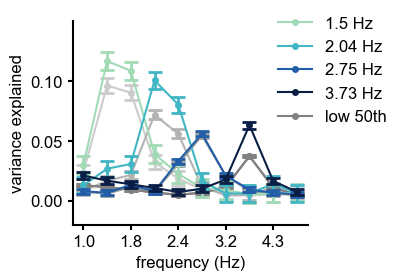

In [22]:
# Plot Vex per frequency, upper versus lower percentile d'
eps=1e-3

vexall =([np.array(data_list["vex"][i][:,np.mean(data_list["vex"][i],axis=0)>eps]).T for i in plt_indices])
shvexall = ([np.array(data_list["shvex"][i][:,np.mean(data_list["vex"][i],axis=0)>eps]).T for i in plt_indices])
low_vexall =([np.array(data_list["low_vex"][i][:,np.mean(data_list["low_vex"][i],axis=0)>eps]).T for i in plt_indices])
low_shvexall = ([np.array(data_list["low_shvex"][i][:,np.mean(data_list["low_vex"][i],axis=0)>eps]).T for i in plt_indices])

perms = list(set(permutations([1, 2, 3])))

shcolors = [[0.8,0.8,0.8],[0.7,0.7,0.7],[0.6,0.6,0.6],[0.5,0.5,0.5]]
vexs = []
shvexs = []
low_vexs = []
low_shvexs = []
vexs_se = []
shvexs_se = []
low_vexs_se = []
low_shvexs_se = []

frs = [1.5, 2.04, 2.75, 3.73]
atol = [0.2,0.2,0.2,0.2]
for fri, fr in enumerate(frs):
    vex = [] 
    shvex = []
    low_vex = [] 
    low_shvex = []
    incl_freq = False
    for i, ni in enumerate(plt_indices):
        if np.isclose(data_list["loss_f"][ni],fr, atol = atol[fri]):
            incl_freq=True
            vex.append(vexall[i])
            shvex.append(shvexall[i])
            low_vex.append(low_vexall[i])
            low_shvex.append(low_shvexall[i])
    if incl_freq:
        print("Including frequency " + str(fr) + " n = " + str(len(vex)))
        vexs.append(np.mean(np.concatenate(vex),axis = 0))
        shvexs.append(np.mean(np.concatenate(shvex),axis = 0))
        vexs_se.append(np.std([np.mean(vex[i]) for i in range(len(shvex))])/np.sqrt(len(vex)))
        shvexs_se.append(np.std([np.mean(shvex[i]) for i in range(len(shvex))])/np.sqrt(len(vex)))
        
        low_vexs.append(np.mean(np.concatenate(low_vex),axis = 0))
        low_shvexs.append(np.mean(np.concatenate(low_shvex),axis = 0))
        low_vexs_se.append(np.std([np.mean(low_vex[i]) for i in range(len(low_shvex))])/np.sqrt(len(low_vex)))
        low_shvexs_se.append(np.std([np.mean(low_shvex[i]) for i in range(len(low_shvex))])/np.sqrt(len(low_vex)))    




with mpl.rc_context(fname="matplotlibrc"):

    fig, axs = plt.subplots(1, figsize=(3.2, 2.7))
    fig.tight_layout()
    for i in range(4):
        axs.errorbar(
            np.arange(len(summary_settings["freqs"])),
            vexs[i],
            vexs_se[i],
            marker="o",
            color=pltcolors_alt[i],
            zorder=i+5,
            capsize=5,
            elinewidth=2,
            markeredgewidth=2,
            label=str(frs[i])+" Hz",
        )  

        axs.errorbar(
            np.arange(len(summary_settings["freqs"])),
            low_vexs[i],
            low_vexs_se[i],
            marker="o",
            color=shcolors[i],
            zorder=i,
            capsize=5,
            elinewidth=2,
            markeredgewidth=2,
        )
    axs.errorbar(
        np.arange(len(summary_settings["freqs"])),
        low_vexs[i],
        low_vexs_se[i],
        marker="o",
        color=shcolors[i],
        zorder=i,
        capsize=5,
        elinewidth=2,
        markeredgewidth=2,
        label="low 50th",
    )
    axs.set_ylim(-0.02, 0.15)
    axs.set_yticks(np.arange(0, 0.13, 0.05))

    axs.set_xticks(np.arange(len(summary_settings["freqs"]))[::2])
    axs.set_xticklabels(["{:.1f}".format(fr) for fr in summary_settings["freqs"][::2]])
    axs.spines["right"].set_visible(False)
    axs.spines["top"].set_visible(False)
    axs.set_ylabel("variance explained")
    axs.set_xlabel("frequency (Hz)")

    handles, labels = axs.get_legend_handles_labels()
    # remove the errorbars
    handles = [h[0] for h in handles]
    # use them in the legend
    plt.legend(
        handles, labels, numpoints=1, loc="upper right", bbox_to_anchor=(1.4, 1.1)
    )
    plt.savefig("../figures/SummF", facecolor="None", transparent=True)
    plt.savefig("../figures/Vex_per_F_and_Perc.eps")

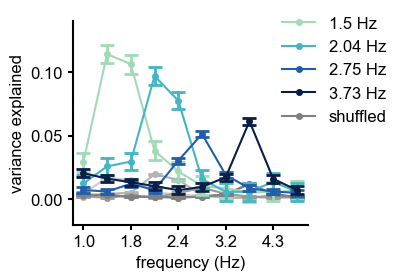

In [15]:
# Plot Vex per frequency, non-shuffled versus shuffled

with mpl.rc_context(fname="matplotlibrc"):

    fig, axs = plt.subplots(1, figsize=(3.2, 2.7))
    # fig.suptitle("Mean circular variance explained", fontsize = 16)
    fig.tight_layout()
    for i in range(4):
        axs.errorbar(
            np.arange(len(summary_settings["freqs"])),
            vexs[i],
            vexs_se[i],
            marker="o",
            color=pltcolors_alt[i],
            zorder=i+5,
            capsize=5,
            elinewidth=2,
            markeredgewidth=2,
            label=str(frs[i])+" Hz",
        )  

        axs.errorbar(
            np.arange(len(summary_settings["freqs"])),
            shvexs[i],#, axis=0),
            shvexs_se[i],
            marker="o",
            color=shcolors[i],
            zorder=i,
            capsize=5,
            elinewidth=2,
            markeredgewidth=2,
        )
    axs.errorbar(
        np.arange(len(summary_settings["freqs"])),
        shvexs[i],#, axis=0),
        shvexs_se[i],
        marker="o",
        color=shcolors[i],
        zorder=i,
        capsize=5,
        elinewidth=2,
        markeredgewidth=2,
        label="shuffled",
    )
    axs.set_ylim(-0.02, 0.14)
    axs.set_yticks(np.arange(0, 0.13, 0.05))

    axs.set_xticks(np.arange(len(summary_settings["freqs"]))[::2])
    axs.set_xticklabels(["{:.1f}".format(fr) for fr in summary_settings["freqs"][::2]])
    axs.spines["right"].set_visible(False)
    axs.spines["top"].set_visible(False)
    axs.set_ylabel("variance explained")
    axs.set_xlabel("frequency (Hz)")

    handles, labels = axs.get_legend_handles_labels()
    # remove the errorbars
    handles = [h[0] for h in handles]
    # use them in the legend
    plt.legend(
        handles, labels, numpoints=1, loc="upper right", bbox_to_anchor=(1.4, 1.1)
    )
    plt.savefig("../figures/SummF", facecolor="None", transparent=True)
    plt.savefig("../figures/VEX_per_F_and_Shuffle.eps")

Including frequency 1.5 n = 7
Including frequency 2.04 n = 6
Including frequency 2.75 n = 6
Including frequency 3.73 n = 9


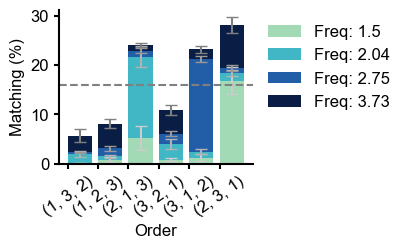

In [9]:
# Plot proportions of phase orders exploited by models from each training frequency

perms = list(set(permutations([1, 2, 3])))

phase_orders = []
phase_orders_v = []
for fr in frs:
    phase_orders_fr = [] 
    incl_freq = False
    for i in plt_indices:
        if np.isclose(data_list["loss_f"][i],fr, atol = 0.2):
            incl_freq=True
            phase_orders_fr.append(np.array(data_list["phase_order"][i])/np.sum(data_list["phase_order"][i]))
    if incl_freq:
        print("Including frequency " + str(fr) + " n = " + str(len(phase_orders_fr)))
        phase_orders.append(np.mean(phase_orders_fr, axis = 0))
        phase_orders_v.append(np.std(phase_orders_fr, axis = 0)/np.sqrt(len(phase_orders_fr)))


with mpl.rc_context(fname="matplotlibrc"):

    plt.subplots(figsize=(2.5, 2))
    ax1 = plt.subplot(111, facecolor="white")  # , projection='polar')
    
    ax1.bar(np.arange(len(perms)),phase_orders[0]*25, color=pltcolors_alt[0],
            yerr=phase_orders_v[0]*25, 
            align='edge',  ecolor=shcolors[0], capsize=4, label ='Freq: '+ str(frs[0]))
    for i in range(1,4):
        ax1.bar(np.arange(len(perms)),phase_orders[i]*25, color=pltcolors_alt[i], bottom = np.sum(phase_orders[:i],axis = 0)*25,
            yerr=phase_orders_v[i]*25, 
            align='edge',  ecolor=shcolors[i], capsize=4, label ='Freq: '+ str(frs[i]))
     
    ax1.legend(bbox_to_anchor = (1,1))
    ax1.axhline(16, linestyle="--", color="grey")
    ax1.set_ylim(0)#, 35)
    ax1.set_xticks(np.arange(len(perms)))
    plt.xticks(rotation=35)
    plt.xlabel("Order")

    ax1.set_xticklabels(perms)
    ax1.set_ylabel("Matching (%)")

    plt.savefig("../figures/model_phaseorders.eps")

Including frequency 1.5 n = 7
Including frequency 2.04 n = 6
Including frequency 2.75 n = 6
Including frequency 3.73 n = 9


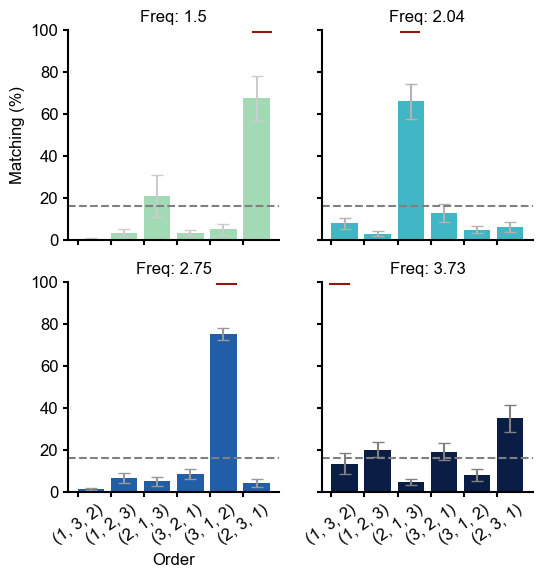

In [10]:
# Plot proportions of phase orders exploited by models from each training frequency, in seperate plots


perms = list(set(permutations([1, 2, 3])))

phase_orders = []
phase_orders_v = []
for fr in frs:
    phase_orders_fr = [] 
    incl_freq = False
    for i in plt_indices:
        if np.isclose(data_list["loss_f"][i],fr, atol = 0.2):
            incl_freq=True
            phase_orders_fr.append(np.array(data_list["phase_order"][i])/np.sum(data_list["phase_order"][i]))
    if incl_freq:
        print("Including frequency " + str(fr) + " n = " + str(len(phase_orders_fr)))
        phase_orders.append(np.mean(phase_orders_fr, axis = 0))
        phase_orders_v.append(np.std(phase_orders_fr, axis = 0)/np.sqrt(len(phase_orders_fr)))
plt.subplots(figsize=(6, 6))

pred = np.array([[5/6,1],[2/6,3/6],[4/6,5/6],[0,1/6]])

with mpl.rc_context(fname="matplotlibrc"):
    for i in range(len(phase_orders)):
        ax1 = plt.subplot(221+i, facecolor="white")  

        ax1.bar(np.arange(len(perms)),phase_orders[i]*100, color=pltcolors_alt[i],
                yerr=phase_orders_v[i]*100, 
                align='edge',  ecolor=shcolors[i], capsize=4, label ='Freq: '+ str(frs[i]))
        ax1.set_title("Freq: "+ str(frs[i]))
        ax1.axhline(16, linestyle="--", color="grey")
        ax1.axhline(99,pred[i][0]+0.04,pred[i][1]-0.04, linestyle="-", color=pltcolors[-1])


        ax1.set_ylim(0,100)
        ax1.set_xticks(np.arange(len(perms)))
        plt.xticks(rotation=35)
        if i>1:
            ax1.set_xticklabels(perms)
        else:
            ax1.set_xticklabels([])
        if i==1 or i==3:
            ax1.set_yticklabels([])



        if i==0:
            ax1.set_ylabel("Matching (%)")
        if i == 2:    
            plt.xlabel("Order")


    plt.savefig("../figures/model_phaseorders_sem.svg", facecolor='white')